In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns
%matplotlib inline

sns.set_style('white')

In [2]:
# Add this repo to the path
import os, sys
src_dir = os.path.normpath(os.path.join(os.getcwd(), '../util'))
sys.path.insert(0, src_dir)
import Formatting as fmt

In [3]:
df = pd.read_csv('../../data/analysis_results/concordance.txt', sep='\t')
df.head()

,dis1,dis2,study1,study2,metric,n_concord,qthresh
0,t1d,par,t1d_alkanani,par_scheperjans,observed,20,1.0
1,t1d,par,t1d_mejialeon,par_scheperjans,observed,28,1.0
2,t1d,noncdi,t1d_alkanani,noncdi_schubert,observed,33,1.0
3,t1d,noncdi,t1d_mejialeon,noncdi_schubert,observed,28,1.0
4,t1d,art,t1d_alkanani,art_scher,observed,26,1.0


In [4]:
# Make pvalues

pvals = []

for g, subdf in df.groupby(['study1','study2', 'qthresh']):
    n_obs = subdf.query('metric == "observed"')['n_concord'].values
    n_exp = subdf.query('metric == "expected"')['n_concord'].values
    p = sum(n_exp >= n_obs)/float(len(n_exp))
    
    pvals.append(list(g) + [p, subdf['dis1'].iloc[0], subdf['dis2'].iloc[0]])

In [5]:
pvalsdf = pd.DataFrame(data=pvals, columns=['study1', 'study2', 'qthresh', 'p', 'dis1', 'dis2'])

In [6]:
pvalsdf.head()

,study1,study2,qthresh,p,dis1,dis2
0,art_scher,asd_kang,1.0,0.000,art,asd
1,art_scher,asd_son,1.0,0.000,art,asd
2,art_scher,cdi_schubert,1.0,0.016,art,cdi
3,art_scher,cdi_singh,1.0,0.000,art,cdi
4,art_scher,cdi_vincent,1.0,0.012,art,cdi


In [7]:
# Add study1-study2 flipped pairs to pivoted df is symmetric
tmp = pvalsdf.copy()
tmp2 = tmp
pvalsdf = pd.concat(
    (pvalsdf, 
     pvalsdf[['study1', 'study2', 'p']].rename(columns={'study1': 'study2', 'study2': 'study1'})))

In [8]:
# order columns
dataset_info = pd.read_csv('../../data/analysis_results/datasets_info.txt', sep='\t')
dataset_info = dataset_info\
    .replace('edd_singh', 'cdi_singh')\
    .replace('noncdi_schubert', 'cdi_schubert2')
_, dataset_order = fmt.get_dataset_order(dataset_info)

In [9]:
# Set up matrix to plot

toplot = pvalsdf.pivot('study2', 'study1', 'p')
toplot = toplot.rename(columns={'noncdi_schubert': 'cdi_schubert2'})
toplot = toplot.loc[dataset_order, dataset_order]

toplot = pd.DataFrame(data=np.tril(np.log10(toplot.values + 1e-6)), columns=toplot.columns, index=toplot.index)
# tril zeros the lower triangle, want this to be nan
toplot = toplot.replace(0, np.nan)

In [11]:
# ## Set up grid spec
# fig = plt.figure(figsize=(6,6))
# # Right bar has a bunch of heatmaps (one for each disease)
# gs = gridspec.GridSpec(1, toplot.shape[1])

# # Get the total number of diseases, and the indices of each
# alldis = []
# for d in dataset_order:
#     d = d.split('_')[0]
#     if d not in alldis:
#         alldis.append(d)

# for dis in alldis:
#     indices = [i for i in range(len(dataset_order))
#                if dataset_order[i].startswith(dis)]
#     # Size each axis (i.e. number of gridspec slots) according to the
#     # number of studies in that disease
#     ax = plt.subplot(gs[:, indices[0]:indices[0]+len(indices)])
#     subdf = toplot[[i for i in toplot.columns if i.startswith(dis)]]
#     _ = ax.imshow(subdf.values, interpolation='nearest', aspect='auto',
#                   cmap=sns.light_palette("gray", reverse=True, as_cmap=True),
#                   vmin=-6, vmax=0)

#     #ax.set_ylim([ax.get_ylim()[0], ax.get_ylim()[1] - 0.5])
#     ax.set_yticklabels([])
#     ax.set_xticks(range(0, subdf.shape[1]))
#     # Align rotated labels with actual bar
#     ax.set_xticks(ax.get_xticks() + 0.4)
#     labels = fmt.get_labeldict(subdf.columns)
#     labels = [labels[i] for i in subdf.columns]
#     ax.set_xticklabels(labels, rotation=45, fontsize='small',
#                        ha='right')
#     ax.spines['bottom'].set_color('gray')
#     ax.spines['left'].set_color('gray')
#     ax.spines['right'].set_color('gray')
#     ax.spines['top'].set_color('gray')

# # Set right-most labels
# ax.yaxis.tick_right()
# ax.yaxis.set_label_position('right')
# labels = fmt.get_labeldict(toplot.index)
# labels = [labels[i] for i in toplot.index]
# ax.set_yticks(np.arange(0.5, len(labels) + 0.5))
# _ = ax.set_yticklabels(labels, fontsize=8, va='bottom')


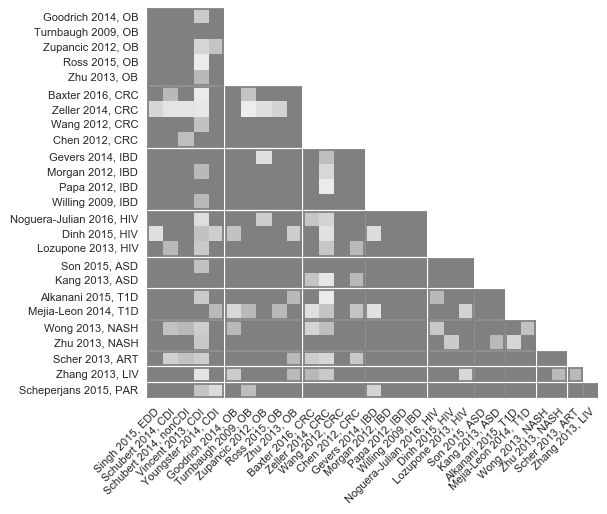

In [38]:
labeldict = fmt.get_labeldict(toplot.index)

## Set up grid spec - boxes around each disease
fig = plt.figure(figsize=(6,6))
# Right bar has a bunch of heatmaps (one for each disease)
gs = gridspec.GridSpec(toplot.shape[0], toplot.shape[1])

# Get the total number of diseases, and the indices of each
alldis = []
for d in dataset_order:
    d = d.split('_')[0]
    if d not in alldis:
        alldis.append(d)

for dis1 in alldis:
    for dis2 in alldis[alldis.index(dis1)+1:]:
        yindices = [i for i in range(len(dataset_order))
                    if dataset_order[i].startswith(dis1)]

        xindices = [i for i in range(len(dataset_order))
                    if dataset_order[i].startswith(dis2)]

        # Size each axis (i.e. number of gridspec slots) according to the
        # number of studies in that disease
        ax = plt.subplot(gs[xindices[0]:xindices[0]+len(xindices), yindices[0]:yindices[0]+len(yindices)])

        cols = [i for i in toplot.index if i.startswith(dis1)]
        rows = [i for i in toplot.columns if i.startswith(dis2)]
        subdf = toplot.loc[rows, cols]
        _ = ax.imshow(subdf.values, interpolation='nearest', aspect='auto',
                      cmap=sns.light_palette("gray", reverse=True, as_cmap=True),
                      vmin=-6, vmax=0)

        ax.spines['bottom'].set_color('gray')
        ax.spines['left'].set_color('gray')
        ax.spines['right'].set_color('gray')
        ax.spines['top'].set_color('gray')

        # Labels
        if dis1 == 'cdi':
            labels = [labeldict[i] for i in subdf.index]
            ax.set_yticks(range(0, subdf.shape[0]))
            _ = ax.set_yticklabels(labels, fontsize=8, va='center')
        else:
            ax.set_yticklabels([])

        if dis2 == 'par':
            labels = [labeldict[i] for i in subdf.columns]
            ax.set_xticks(range(0, subdf.shape[1]))
            # Align rotated labels with actual bar
            ax.set_xticks(ax.get_xticks() + 0.4)
            _ = ax.set_xticklabels(labels, rotation=45, fontsize=8, ha='right')
        else:
            ax.set_xticklabels([])
